In [43]:
import re
import pandas as pd
import numpy as np
import emoji
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk import *
from datetime import date
import plotly.express as px
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import text2emotion as te
# for text cleaning
import neattext.functions as nfx
from textblob import TextBlob

# Extract Time
def date_time(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

# Find Authors or Contacts
def find_author(s):
    s = s.split(":")
    if len(s)==2:
        return True
    else:
        return False

# Finding Messages
def getDatapoint(line):
    splitline = line.split(' - ')
    dateTime = splitline[0]
    date, time = dateTime.split(", ")
    message = " ".join(splitline[1:])
    if find_author(message):
        splitmessage = message.split(": ")
        author = splitmessage[0]
        message = " ".join(splitmessage[1:])
    else:
        author= None
    return date, time, author, message

In [46]:
data = []
conversation = 'whatsapp chat.txt'
with open(conversation, encoding="utf-8") as fp:
    fp.readline()
    messageBuffer = []
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if date_time(line):
            if len(messageBuffer) > 0:
                data.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDatapoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

# unsupervised learning 

In [47]:
df = pd.DataFrame(data, columns=['Date', 'Time', 'Author', 'Message'])
df['Date'] = pd.to_datetime(df['Date'])

df


Date      Time               Author  \
0    2018-05-05   5:56 PM                 None   
1    2018-07-24  12:13 AM                 None   
2    2018-07-24   2:09 AM                 None   
3    2018-07-24   7:52 AM  ‪+234 812 215 1697‬   
4    2018-07-24   7:53 AM         YTC Olushayo   
...         ...       ...                  ...   
4373 2018-08-21   7:06 PM  ‪+234 909 272 2864‬   
4374 2018-08-21   7:07 PM    YabaTech Informat   
4375 2018-08-21   7:08 PM  ‪+234 909 272 2864‬   
4376 2018-08-21   7:12 PM    YabaTech Informat   
4377 2018-08-21   7:35 PM                 None   

                                                Message  
0     YabaTech Informat created group "YABATECH 2018...  
1             You joined using this group's invite link  
2                              ‪+234 816 350 1946‬ left  
3                              Waiting for this message  
4                                                    No  
...                                                 ...  
4373        Are we supposed to  our upload our results?  
4374                                      Upload to whr  
4375                                          Jamb caps  
4376                                               No o  
4377  ‪+234 813 781 4116‬: JAMB CAPS for 2018/2019 A...  

[4378 rows x 4 columns]

# creating new columns year, month, day, time, hour, minute, weeday

In [48]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month_name()
df['day'] = df['Date'].dt.day
df['Time'] = pd.to_datetime(df['Time'])
df['hour'] = df['Time'].dt.hour
df['minute'] = df['Time'].dt.minute
df['weekday'] = df['Date'].dt.day_name()

df.head()

Date                Time               Author  \
0 2018-05-05 2022-02-24 17:56:00                 None   
1 2018-07-24 2022-02-24 00:13:00                 None   
2 2018-07-24 2022-02-24 02:09:00                 None   
3 2018-07-24 2022-02-24 07:52:00  ‪+234 812 215 1697‬   
4 2018-07-24 2022-02-24 07:53:00         YTC Olushayo   

                                             Message  year month  day  hour  \
0  YabaTech Informat created group "YABATECH 2018...  2018   May    5    17   
1          You joined using this group's invite link  2018  July   24     0   
2                           ‪+234 816 350 1946‬ left  2018  July   24     2   
3                           Waiting for this message  2018  July   24     7   
4                                                 No  2018  July   24     7   

   minute   weekday  
0      56  Saturday  
1      13   Tuesday  
2       9   Tuesday  
3      52   Tuesday  
4      53   Tuesday

# # split URL, letter and word count 

In [49]:
#column urlcount
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

#column Letter_Count
df['Letter_Count'] = df['Message'].apply(lambda s : len(s))
#column Word_Count
df['Word_Count'] = df['Message'].apply(lambda s : len(s.split(' ')))
df.head()

Date                Time               Author  \
0 2018-05-05 2022-02-24 17:56:00                 None   
1 2018-07-24 2022-02-24 00:13:00                 None   
2 2018-07-24 2022-02-24 02:09:00                 None   
3 2018-07-24 2022-02-24 07:52:00  ‪+234 812 215 1697‬   
4 2018-07-24 2022-02-24 07:53:00         YTC Olushayo   

                                             Message  year month  day  hour  \
0  YabaTech Informat created group "YABATECH 2018...  2018   May    5    17   
1          You joined using this group's invite link  2018  July   24     0   
2                           ‪+234 816 350 1946‬ left  2018  July   24     2   
3                           Waiting for this message  2018  July   24     7   
4                                                 No  2018  July   24     7   

   minute   weekday  urlcount  Letter_Count  Word_Count  
0      56  Saturday         0            59           7  
1      13   Tuesday         0            41           7  
2       9   Tuesday         0            24           5  
3      52   Tuesday         0            24           4  
4      53   Tuesday         0             2           1

# extract emoji in message

In [50]:

def split_count(text):
    emoji_list = []
    data = re.findall(u'[\U0001f300-\U0001f650]|[\u2000-\u3000]', text)
#     data = re.findall(u'(?:\uD83C[\uDF00-\uDFFF])|(?:\uD83D[\uDC00-\uDDFF])', text)
    
#     print(data)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
#             print(emoji_list)
    return emoji_list

df["emoji"] = df["Message"].apply(split_count)
df.head(50)

Date                Time               Author  \
0  2018-05-05 2022-02-24 17:56:00                 None   
1  2018-07-24 2022-02-24 00:13:00                 None   
2  2018-07-24 2022-02-24 02:09:00                 None   
3  2018-07-24 2022-02-24 07:52:00  ‪+234 812 215 1697‬   
4  2018-07-24 2022-02-24 07:53:00         YTC Olushayo   
5  2018-07-24 2022-02-24 08:46:00   YTC Prince Oluwafe   
6  2018-07-24 2022-02-24 09:01:00  ‪+234 811 529 4170‬   
7  2018-07-24 2022-02-24 09:03:00  ‪+234 812 215 1697‬   
8  2018-07-24 2022-02-24 09:23:00  ‪+234 812 215 1697‬   
9  2018-07-24 2022-02-24 09:26:00  ‪+234 812 215 1697‬   
10 2018-07-24 2022-02-24 13:01:00                 None   
11 2018-07-24 2022-02-24 10:04:00       YTC Firsiryour   
12 2018-07-24 2022-02-24 10:13:00  ‪+234 818 020 6450‬   
13 2018-07-24 2022-02-24 10:14:00  ‪+234 812 215 1697‬   
14 2018-07-24 2022-02-24 10:15:00  ‪+234 812 215 1697‬   
15 2018-07-24 2022-02-24 10:19:00       YTC Firsiryour   
16 2018-07-24 2022-02-24 10:20:00       YTC Firsiryour   
17 2018-07-24 2022-02-24 10:20:00       YTC Firsiryour   
18 2018-07-24 2022-02-24 12:43:00           YTC Daniel   
19 2018-07-24 2022-02-24 12:46:00           YTC Daniel   
20 2018-07-24 2022-02-24 12:50:00                 None   
21 2018-07-24 2022-02-24 13:19:00           YTC Daniel   
22 2018-07-24 2022-02-24 13:47:00         YTC Temitope   
23 2018-07-24 2022-02-24 14:20:00         YTC Emmanuel   
24 2018-07-24 2022-02-24 14:42:00  ‪+234 706 398 6383‬   
25 2018-07-24 2022-02-24 15:55:00                 None   
26 2018-07-24 2022-02-24 16:08:00  ‪+234 815 879 3357‬   
27 2018-07-24 2022-02-24 16:20:00  ‪+234 812 215 1697‬   
28 2018-07-24 2022-02-24 16:42:00                 None   
29 2018-07-24 2022-02-24 17:04:00                 None   
30 2018-07-24 2022-02-24 17:07:00          YTC Chi Eze   
31 2018-07-24 2022-02-24 18:16:00        YTC Wf Dhanny   
32 2018-07-24 2022-02-24 22:50:00                 None   
33 2018-07-24 2022-02-24 19:07:00                 None   
34 2018-07-24 2022-02-24 19:15:00      YTC Ife Unusual   
35 2018-07-24 2022-02-24 22:51:00  ‪+234 816 890 6884‬   
36 2018-07-24 2022-02-24 22:58:00  ‪+234 816 561 6819‬   
37 2018-07-24 2022-02-24 23:58:00        YTC Emmanuel2   
38 2018-07-25 2022-02-24 13:40:00                 None   
39 2018-07-26 2022-02-24 08:46:00                 None   
40 2018-07-26 2022-02-24 14:39:00                 None   
41 2018-07-26 2022-02-24 15:07:00                 None   
42 2018-07-26 2022-02-24 17:43:00                 None   
43 2018-07-25 2022-02-24 13:35:00           YTC Khinde   
44 2018-07-25 2022-02-24 14:22:00          YTC Meeksax   
45 2018-07-25 2022-02-24 14:23:00  ‪+234 816 890 6884‬   
46 2018-07-25 2022-02-24 14:30:00          YTC Meeksax   
47 2018-07-25 2022-02-24 14:43:00           YTC Khinde   
48 2018-07-25 2022-02-24 14:46:00  ‪+234 703 794 5112‬   
49 2018-07-25 2022-02-24 14:48:00  ‪+234 703 794 5112‬   

                                              Message  year month  day  hour  \
0   YabaTech Informat created group "YABATECH 2018...  2018   May    5    17   
1           You joined using this group's invite link  2018  July   24     0   
2                            ‪+234 816 350 1946‬ left  2018  July   24     2   
3                            Waiting for this message  2018  July   24     7   
4                                                  No  2018  July   24     7   
5   A student failed JAMB 5 tyms. 1 day, she trave...  2018  July   24     8   
6                        Please is Yaba HND form out?  2018  July   24     9   
7                                      Yes I think so  2018  July   24     9   
8   Please oh house this aggregate score of a thin...  2018  July   24     9   
9                   As in  189 divide by 400 times 50  2018  July   24     9   
10  YTC Marvelzi joined using this group's invite ...  2018  July   24    13   
11      This gives the same as dividing ur score by 8  2018  July   24    10   
12        

# chart shows the number of messages on weekdays and weekends (Time Series)

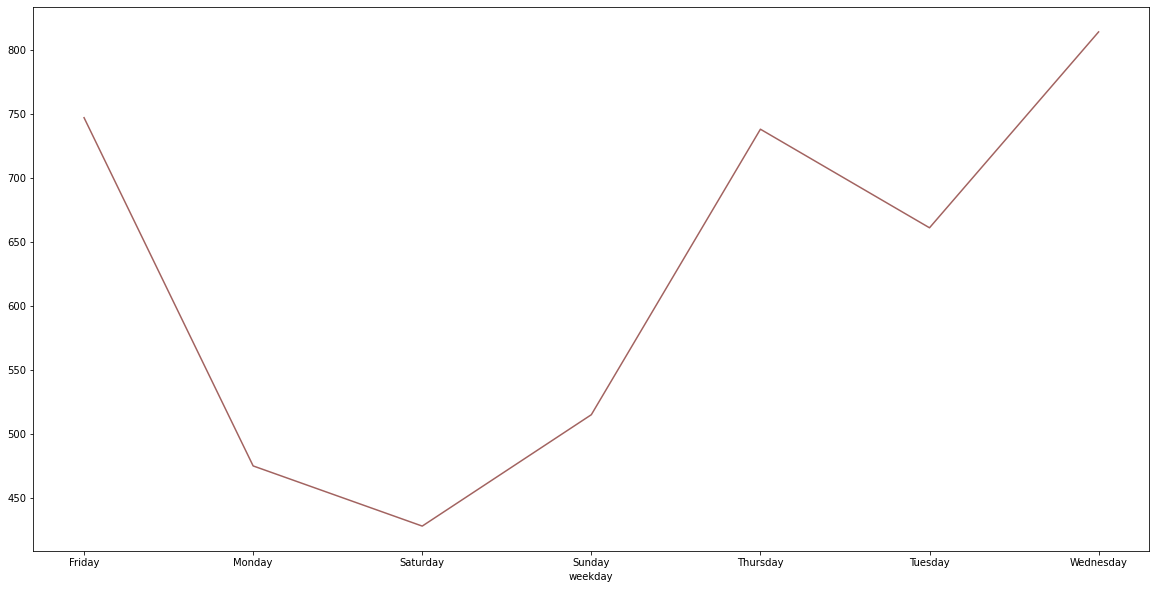

In [8]:
date_grouped = df.groupby('weekday')['Message'].count().plot(kind='line', figsize=(20,10), color='#A26360')

# chart shows the number of messages date wise

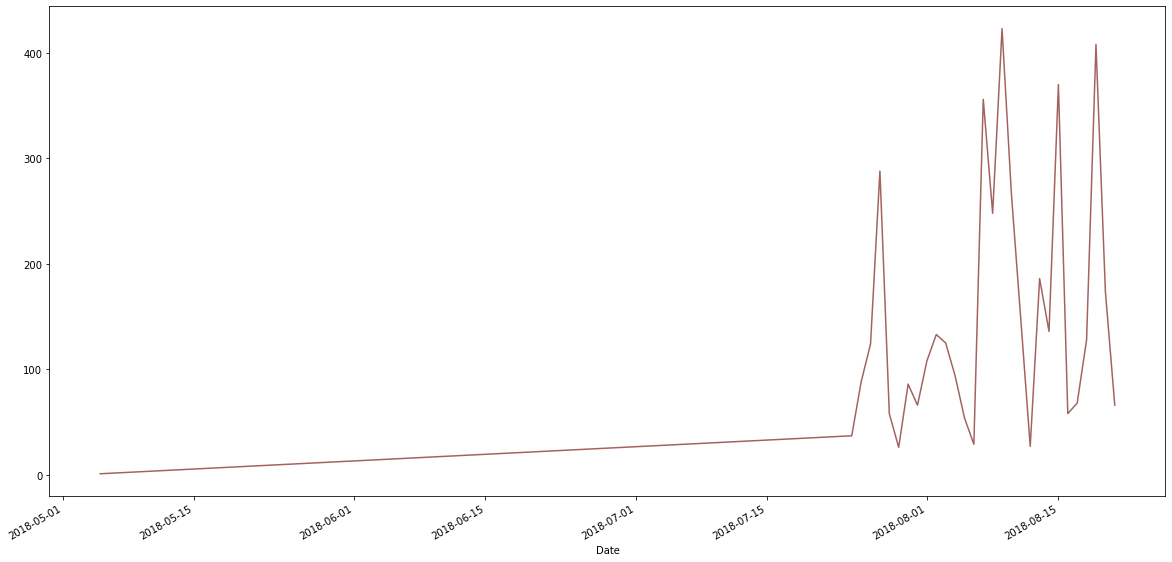

In [9]:
date_grouped = df.groupby('Date')['Message'].count().plot(kind='line', figsize=(20,10), color='#A26360')

# favorite days to chat with friends

In [9]:
weekday_grouped_msg =  (df.set_index('weekday')['Message']
                          .groupby(level=0)
                          .value_counts()
                          .groupby(level=0)
                          .sum()
                          .reset_index(name='count'))
weekday_grouped_msg

fig = px.line_polar(weekday_grouped_msg, r='count', theta='weekday', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

# Total Messages per hour

In [10]:
hour_grouped_msg =  (df.set_index('hour')['Message']
                          .groupby(level=0)
                          .value_counts()
                          .groupby(level=0)
                          .sum()
                          .reset_index(name='count'))
fig = px.bar(hour_grouped_msg, x='hour', y='count',
                 labels={'hour':'24 Hour Period'}, 
                 height=400)
fig.update_traces(marker_color='#EDCC8B', marker_line_color='#D4A29C',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Total Messages by Hour of the Day')
fig.show()

# pivot table day wise and month wise

In [11]:
grouped_by_month_and_day = df.groupby(['month', 'weekday'])['Message'].value_counts().reset_index(name='count')
grouped_by_month_and_day
months= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pt = grouped_by_month_and_day.pivot_table(index= 'month', columns= 'weekday', values='count').reindex(index=months, columns= days)
fig = px.imshow(pt,
                labels=dict(x="Day of Week", y="Months", color="Count"),
                x=days,
                y=months
               )
fig.update_layout(
    width = 700, height = 700)
fig.show()

# which author sent maximum messages 

YTC Ifeanyi          254
YabaTech Informat    247
YTC Icekay           196
YTC Kef              177
YTC Emmanuel         170
YTC Furzito          165
YTC Bobby Fresh      155
YTC Ayoola           142
YTC b_b              115
YTC Sunshine         113
Name: Author, dtype: int64

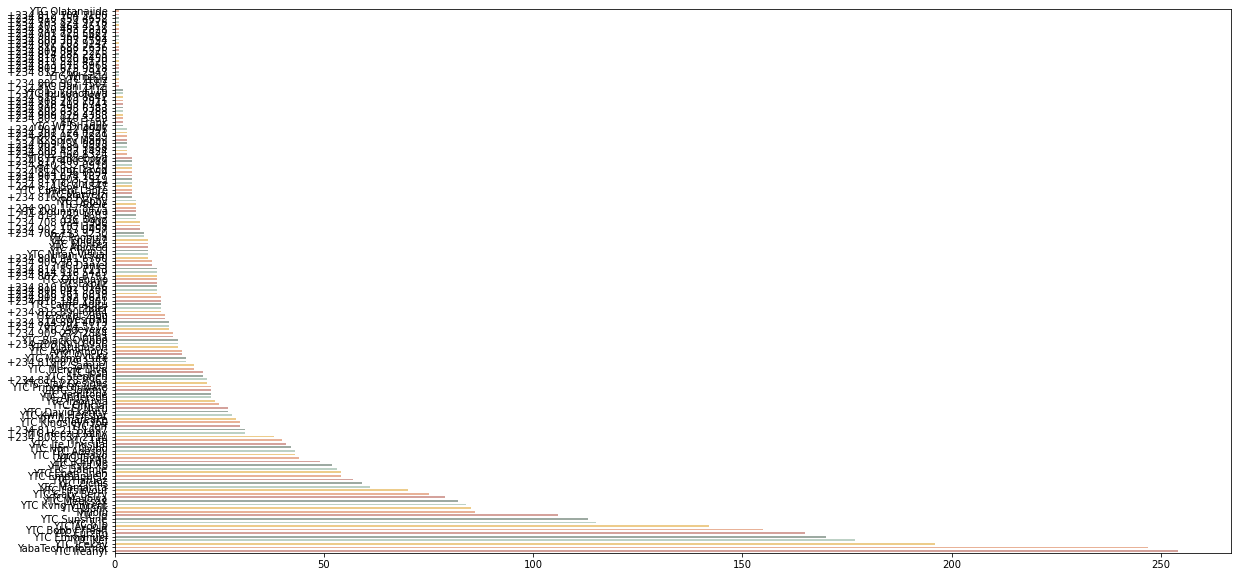

In [10]:
qty_message_author = df['Author'].value_counts()
qty_message_author.plot(kind='barh',figsize=(20,10), color=['#D4A29C', '#E8B298', '#EDCC8B', '#BDD1C5', '#9DAAA2'])
qty_message_author.head(10)

# find common words and their frequency

In [13]:
commond_words = df[['Author','Message']].copy()

from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')

stopwords = list(STOPWORDS)
extra = ["<multimedia", "omitido>", "k", "d","si","multimedia", "omitido"]
stopwords = stopwords + extra
commond_words["Message"] = (commond_words["Message"]
                           .str.lower()
                           .str.split()
                           .apply(lambda x: [item for item in x if item not in stopwords])
                           .explode()
                           .reset_index(drop=True)
                 )

# commond_words['Message']= commond_words['Message'].apply(remove_emoji)
commond_words['Message']= commond_words['Message'].replace('nan', np.NaN)
commond_words['Message']= commond_words['Message'].replace('', np.NaN)
commond_words['Message']= commond_words.Message.str.replace(r"(a|j)?(ja)+(a|j)?", "jaja",regex=True)
commond_words['Message']= commond_words.Message.str.replace(r"(a|j)?(jaja)+(a|j)?", "jaja",regex=True)


words_dict = dict(Counter(commond_words.Message))
words_dict = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)

words_dict = pd.DataFrame(words_dict, columns=['words', 'count'])

fig = px.bar(words_dict.head(10).dropna(), x='words', y='count',
                 labels={'words':'Common Words'}, 
                 height=400)
fig.update_traces(marker_color='#EDCC8B', marker_line_color='#D4A29C',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Commond Words Chart')
fig.show()

In [11]:
#function to display wordcloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

#function to remove urls from text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

# word cloud

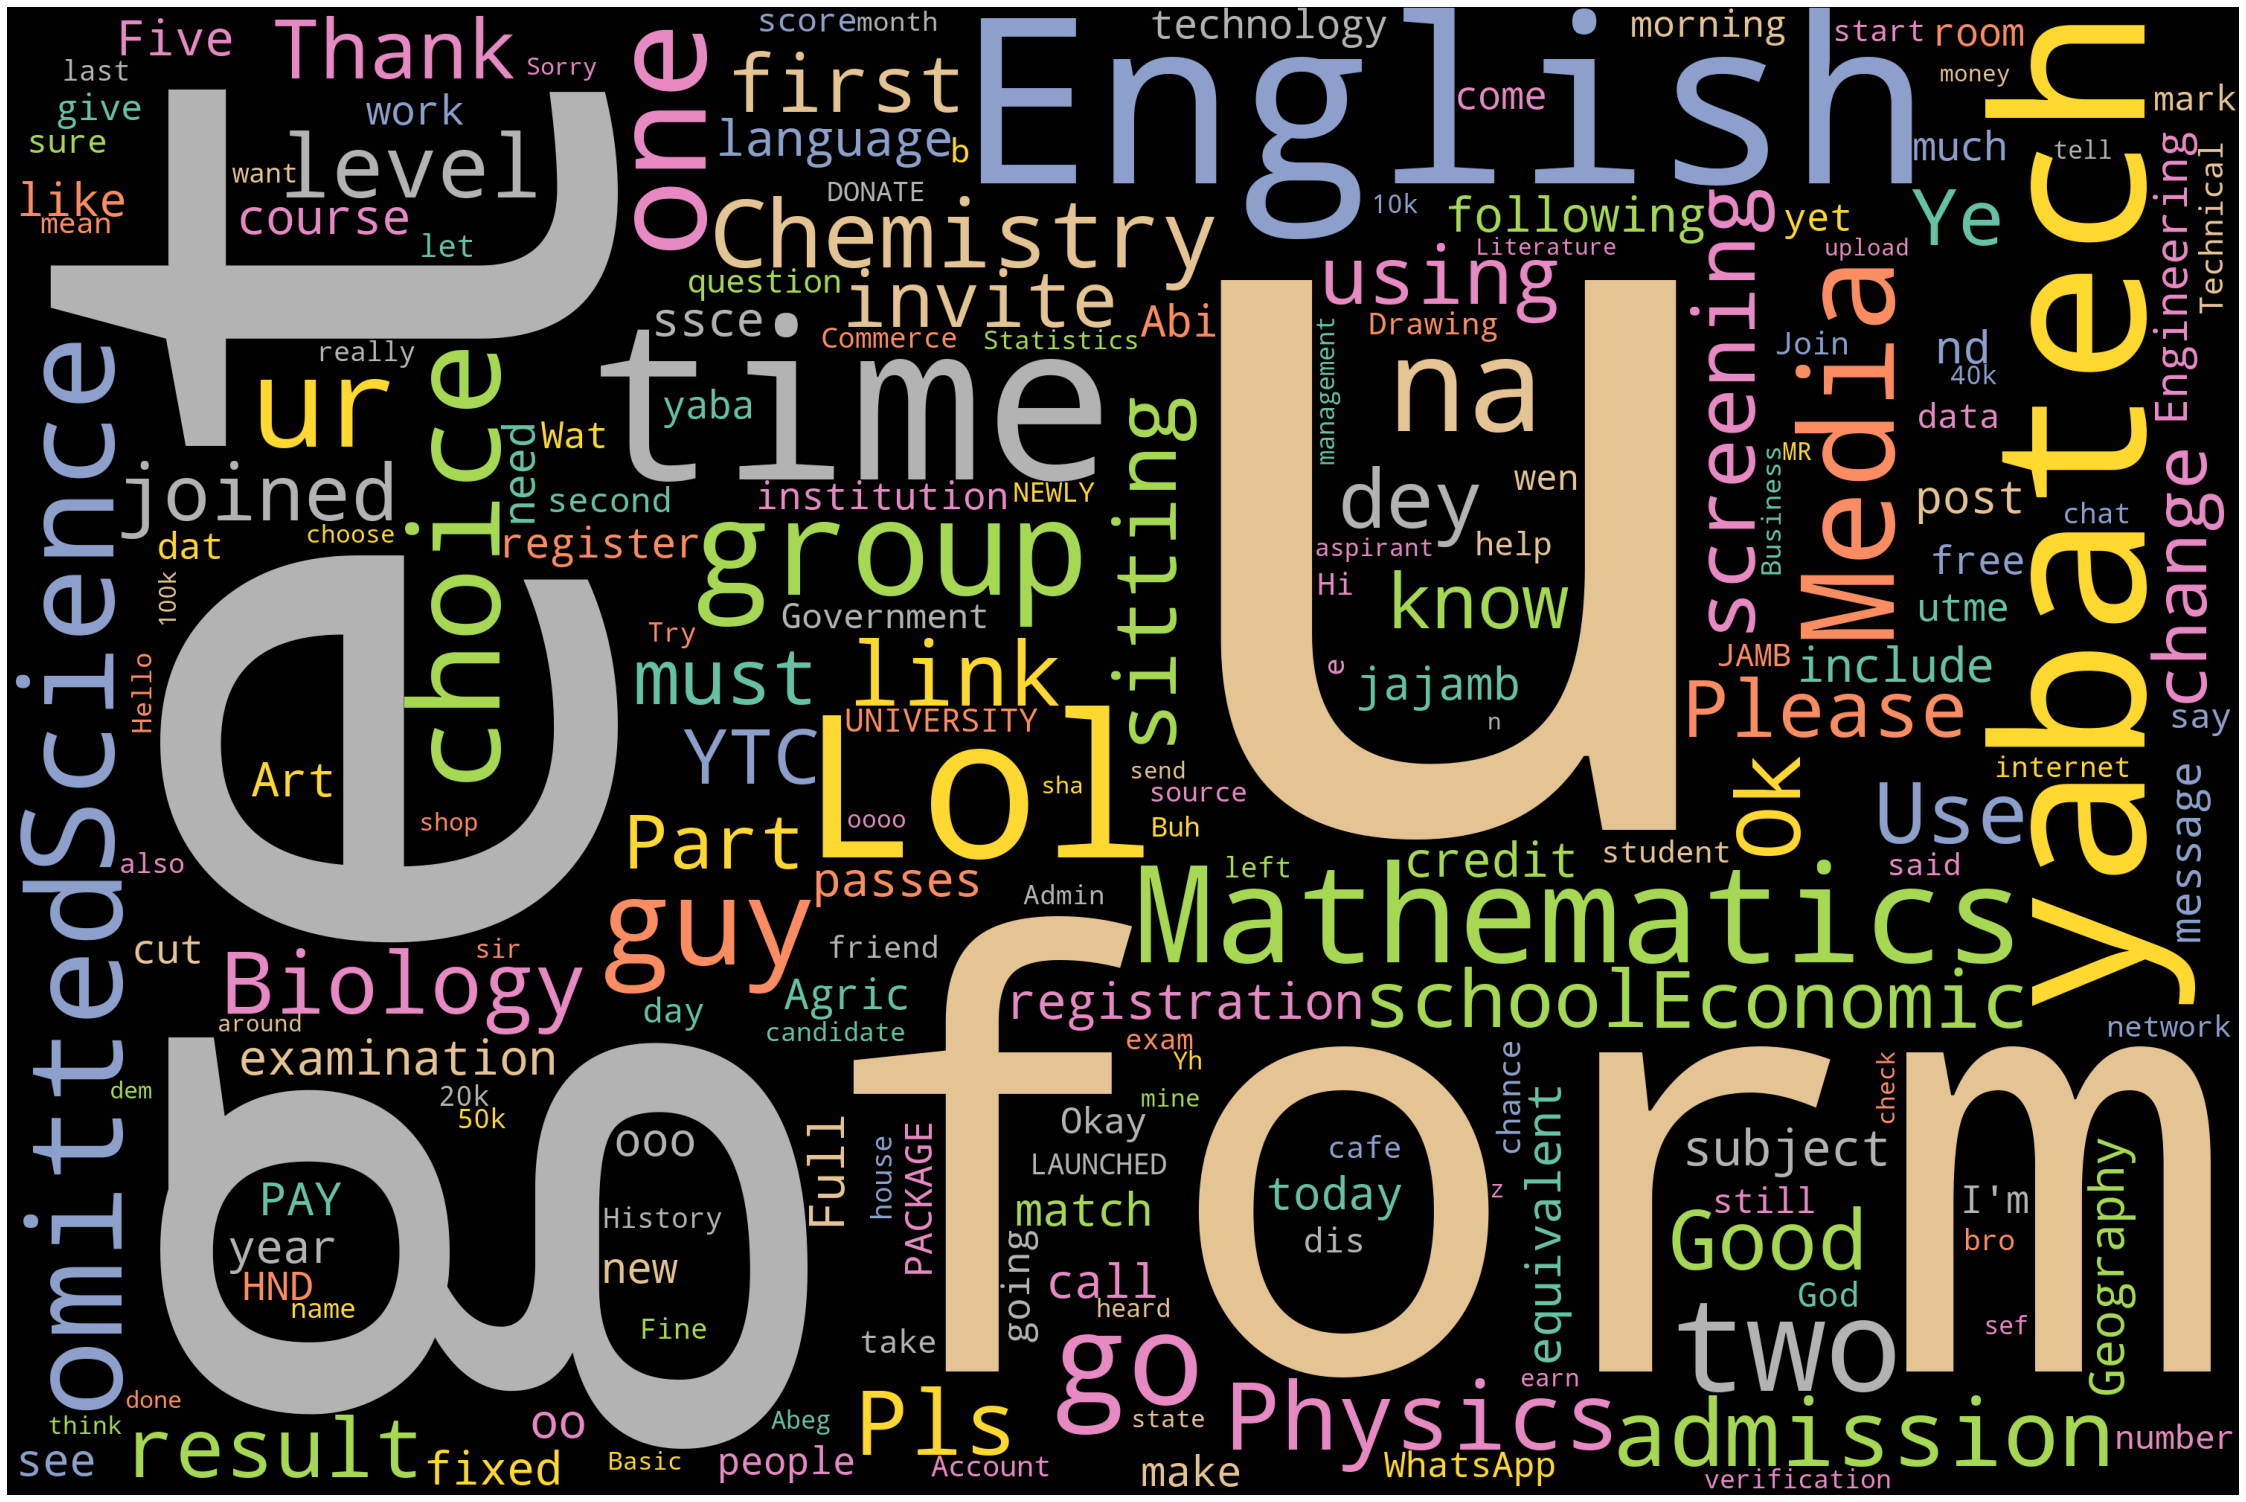

In [15]:
chat_word_cloud = df[['Message']].copy()
# chat_word_cloud['Message']= chat_word_cloud['Message'].apply(remove_emoji)
chat_word_cloud['Message']= chat_word_cloud['Message'].apply(remove_urls)
chat_word_cloud['Message']= chat_word_cloud['Message'].replace('nan', np.NaN)
chat_word_cloud['Message']= chat_word_cloud['Message'].replace('', np.NaN)
chat_word_cloud['Message']= chat_word_cloud.Message.str.replace(r"(a|j)?(ja)+(a|j)?", "jaja",regex=True)
chat_word_cloud['Message']= chat_word_cloud.Message.str.replace(r"(a|j)?(jaja)+(a|j)?", "jaja",regex=True)
text = " ".join(review for review in chat_word_cloud.Message.dropna())
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
background_color='black', colormap='Set2', collocations=False,
stopwords = stopwords).generate(text)

plot_cloud(wordcloud)

In [16]:
df.head(10)

Date                Time               Author  \
0 2018-05-05 2022-02-11 17:56:00                 None   
1 2018-07-24 2022-02-11 00:13:00                 None   
2 2018-07-24 2022-02-11 02:09:00                 None   
3 2018-07-24 2022-02-11 07:52:00  ‪+234 812 215 1697‬   
4 2018-07-24 2022-02-11 07:53:00         YTC Olushayo   
5 2018-07-24 2022-02-11 08:46:00   YTC Prince Oluwafe   
6 2018-07-24 2022-02-11 09:01:00  ‪+234 811 529 4170‬   
7 2018-07-24 2022-02-11 09:03:00  ‪+234 812 215 1697‬   
8 2018-07-24 2022-02-11 09:23:00  ‪+234 812 215 1697‬   
9 2018-07-24 2022-02-11 09:26:00  ‪+234 812 215 1697‬   

                                             Message  year month  day  hour  \
0  YabaTech Informat created group "YABATECH 2018...  2018   May    5    17   
1          You joined using this group's invite link  2018  July   24     0   
2                           ‪+234 816 350 1946‬ left  2018  July   24     2   
3                           Waiting for this message  2018  July   24     7   
4                                                 No  2018  July   24     7   
5  A student failed JAMB 5 tyms. 1 day, she trave...  2018  July   24     8   
6                       Please is Yaba HND form out?  2018  July   24     9   
7                                     Yes I think so  2018  July   24     9   
8  Please oh house this aggregate score of a thin...  2018  July   24     9   
9                  As in  189 divide by 400 times 50  2018  July   24     9   

   minute   weekday  urlcount  Letter_Count  Word_Count                  emoji  
0      56  Saturday         0            59           7                     []  
1      13   Tuesday         0            41           7                     []  
2       9   Tuesday         0            24           5                     []  
3      52   Tuesday         0            24           4                     []  
4      53   Tuesday         0             2           1                     []  
5      46   Tuesday         0           620         132  [😆, 😆, 😆, 😆, 😆, 😆, 😆]  
6       1   Tuesday         0            28           6                     []  
7       3   Tuesday         0            14           4                     []  
8      23   Tuesday         0           176          39                     []  
9      26   Tuesday         0            33           9                     []

# Find sentiments of messages

In [51]:
data = df
dfd = pd.DataFrame(data, columns=['Author', 'Message'])

data = dfd.dropna()

sentiments = SentimentIntensityAnalyzer()
data["Pos"] = [sentiments.polarity_scores(i)["pos"] for i in data["Message"]]
data["Neg"] = [sentiments.polarity_scores(i)["neg"] for i in data["Message"]]
data["Neu"] = [sentiments.polarity_scores(i)["neu"] for i in data["Message"]]

print(data.head(10))

C:\Users\Bhao\AppData\Local\Temp/ipykernel_3388/387187661.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Pos"] = [sentiments.polarity_scores(i)["pos"] for i in data["Message"]]
C:\Users\Bhao\AppData\Local\Temp/ipykernel_3388/387187661.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Neg"] = [sentiments.polarity_scores(i)["neg"] for i in data["Message"]]


                 Author                                            Message  \
3   ‪+234 812 215 1697‬                           Waiting for this message   
4          YTC Olushayo                                                 No   
5    YTC Prince Oluwafe  A student failed JAMB 5 tyms. 1 day, she trave...   
6   ‪+234 811 529 4170‬                       Please is Yaba HND form out?   
7   ‪+234 812 215 1697‬                                     Yes I think so   
8   ‪+234 812 215 1697‬  Please oh house this aggregate score of a thin...   
9   ‪+234 812 215 1697‬                  As in  189 divide by 400 times 50   
11       YTC Firsiryour      This gives the same as dividing ur score by 8   
12  ‪+234 818 020 6450‬                                         Are u sure   
13  ‪+234 812 215 1697‬                  If u think so u are not sure then   

      Pos    Neg    Neu  
3   0.000  0.000  1.000  
4   0.000  1.000  0.000  
5   0.160  0.052  0.788  
6   0.315  0.000  0.685  
7   0.574  

C:\Users\Bhao\AppData\Local\Temp/ipykernel_3388/387187661.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Neu"] = [sentiments.polarity_scores(i)["neu"] for i in data["Message"]]


# Bar chart to represent sentiments of messages

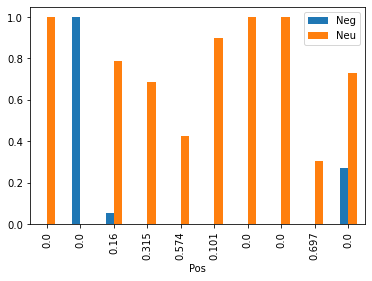

In [18]:
data1 = data.head(10)
data1.plot(x="Pos", y=["Neg", "Neu"], kind="bar")
plt.show()

# Emotions of messages 

In [120]:

for i in data["Message"]:
    print(te.get_emotion(i))


{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 1.0, 'Sad': 0.0, 'Fear': 0.0}
{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad': 0, 'Fear': 0}
{'Happy': 0.18, 'Angry': 0.04, 'Surprise': 0.43, 'Sad': 0.21, 'Fear': 0.14}
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 1.0, 'Fear': 0.0}
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.5, 'Sad': 0.5, 'Fear': 0.0}
{'Happy': 0.0, 'Angry': 0.29, 'Surprise': 0.43, 'Sad': 0.14, 'Fear': 0.14}
{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad': 0, 'Fear': 0}
{'Happy': 0.0, 'Angry': 0.5, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 0.5}
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 1.0}
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.5, 'Sad': 0.0, 'Fear': 0.5}
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.5, 'Sad': 0.0, 'Fear': 0.5}
{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad': 0, 'Fear': 0}
{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad': 0, 'Fear': 0}
{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad': 0, 'Fear': 0}
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.33, 

KeyboardInterrupt: 

In [52]:
data['sentiment'] = data[['Pos','Neg','Neu']].idxmax(axis=1)
data

C:\Users\Bhao\AppData\Local\Temp/ipykernel_3388/853022839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data[['Pos','Neg','Neu']].idxmax(axis=1)


Author                                            Message  \
3     ‪+234 812 215 1697‬                           Waiting for this message   
4            YTC Olushayo                                                 No   
5      YTC Prince Oluwafe  A student failed JAMB 5 tyms. 1 day, she trave...   
6     ‪+234 811 529 4170‬                       Please is Yaba HND form out?   
7     ‪+234 812 215 1697‬                                     Yes I think so   
...                   ...                                                ...   
4372              YTC b_b                  can you just stop this already 🙄🙄   
4373  ‪+234 909 272 2864‬        Are we supposed to  our upload our results?   
4374    YabaTech Informat                                      Upload to whr   
4375  ‪+234 909 272 2864‬                                          Jamb caps   
4376    YabaTech Informat                                               No o   

        Pos    Neg    Neu sentiment  
3     0.000  0.000  1.000       Neu  
4     0.000  1.000  0.000       Neg  
5     0.160  0.052  0.788       Neu  
6     0.315  0.000  0.685       Neu  
7     0.574  0.000  0.426       Pos  
...     ...    ...    ...       ...  
4372  0.000  0.268  0.732       Neu  
4373  0.000  0.000  1.000       Neu  
4374  0.000  0.000  1.000       Neu  
4375  0.000  0.000  1.000       Neu  
4376  0.000  1.000  0.000       Neg  

[4210 rows x 6 columns]

# find freq of Positive , Negative and Neutral

<AxesSubplot:>

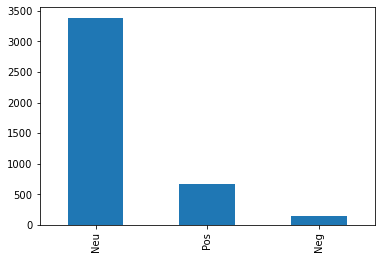

In [53]:
data['sentiment'].value_counts()
plt.figure(figsize=(6,4))
data['sentiment'].value_counts().plot(kind='bar')

In [60]:
data['clean_text'] = data['Message'].apply(nfx.remove_stopwords)


C:\Users\Bhao\AppData\Local\Temp/ipykernel_3388/1872116344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_text'] = data['Message'].apply(nfx.remove_stopwords)


In [61]:
data['clean_text'] = data['clean_text'].apply(nfx.remove_userhandles)

C:\Users\Bhao\AppData\Local\Temp/ipykernel_3388/75983783.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_text'] = data['clean_text'].apply(nfx.remove_userhandles)


In [62]:
data['clean_text'] = data['clean_text'].apply(nfx.remove_punctuations)

C:\Users\Bhao\AppData\Local\Temp/ipykernel_3388/642700368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_text'] = data['clean_text'].apply(nfx.remove_punctuations)


# Compare clean text and unclean text

In [63]:
data[['Message', 'clean_text']].head(20)

Message  \
3                            Waiting for this message   
4                                                  No   
5   A student failed JAMB 5 tyms. 1 day, she trave...   
6                        Please is Yaba HND form out?   
7                                      Yes I think so   
8   Please oh house this aggregate score of a thin...   
9                   As in  189 divide by 400 times 50   
11      This gives the same as dividing ur score by 8   
12                                         Are u sure   
13                  If u think so u are not sure then   
14  It can't be the same because 182 divide by 400...   
15                              U do maths for school   
16                                    <Media omitted>   
17                                    <Media omitted>   
18      Pls add this number 09021517548 to the group.   
19                                     Admins abeg!!!   
21                                  Gracias amigos.👍🏿   
22                           Waiting for this message   
23                                           Amen ooo   
24                                                Hmm   

                                           clean_text  
3                                     Waiting message  
4                                                      
5   student failed JAMB 5 tyms 1 day travelled 2 v...  
6                                   Yaba HND form out  
7                                           Yes think  
8   oh house aggregate score thing number divide j...  
9                             189 divide 400 times 50  
11                          gives dividing ur score 8  
12                                             u sure  
13                                     u think u sure  
14  cant 182 divide 400 time 50 u thing 182 divide...  
15                                     U maths school  
16                                    <Media omitted>  
17                                    <Media omitted>  
18                   Pls add number 09021517548 group  
19                                        Admins abeg  
21                                   Gracias amigos👍🏿  
22                                    Waiting message  
23                                           Amen ooo  
24                                                Hmm

In [64]:
data

Author                                            Message  \
3     ‪+234 812 215 1697‬                           Waiting for this message   
4            YTC Olushayo                                                 No   
5      YTC Prince Oluwafe  A student failed JAMB 5 tyms. 1 day, she trave...   
6     ‪+234 811 529 4170‬                       Please is Yaba HND form out?   
7     ‪+234 812 215 1697‬                                     Yes I think so   
...                   ...                                                ...   
4372              YTC b_b                  can you just stop this already 🙄🙄   
4373  ‪+234 909 272 2864‬        Are we supposed to  our upload our results?   
4374    YabaTech Informat                                      Upload to whr   
4375  ‪+234 909 272 2864‬                                          Jamb caps   
4376    YabaTech Informat                                               No o   

        Pos    Neg    Neu sentiment  \
3     0.000  0.000  1.000       Neu   
4     0.000  1.000  0.000       Neg   
5     0.160  0.052  0.788       Neu   
6     0.315  0.000  0.685       Neu   
7     0.574  0.000  0.426       Pos   
...     ...    ...    ...       ...   
4372  0.000  0.268  0.732       Neu   
4373  0.000  0.000  1.000       Neu   
4374  0.000  0.000  1.000       Neu   
4375  0.000  0.000  1.000       Neu   
4376  0.000  1.000  0.000       Neg   

                                             clean_text  
3                                       Waiting message  
4                                                        
5     student failed JAMB 5 tyms 1 day travelled 2 v...  
6                                     Yaba HND form out  
7                                             Yes think  
...                                                 ...  
4372                                            stop 🙄🙄  
4373                            supposed upload results  
4374                                         Upload whr  
4375                                          Jamb caps  
4376                                                     

[4210 rows x 7 columns]

In [66]:
# ML pkgs
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import MultinomialNB

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [67]:
# split out dataset
from sklearn.model_selection import train_test_split

In [94]:
Xfeature = data['Message']
Ylables = data['sentiment']

In [95]:
cv = CountVectorizer()
x = cv.fit_transform(Xfeature)

In [96]:
cv.get_feature_names()

C:\Users\Bhao\Anaconda3\envs\plotlyenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00',
 '000',
 '000k',
 '04',
 '07017255622',
 '07033435819',
 '07034644517',
 '07067978345',
 '07085093528',
 '07089343900',
 '08',
 '08030004900',
 '08037128774',
 '08067417697',
 '08092255687',
 '08118596777',
 '0812',
 '08166882636',
 '08167203922',
 '08167404275',
 '08177826721',
 '08180872529',
 '08182162040',
 '09',
 '09021517548',
 '09027258735',
 '09077039147',
 '09082990252',
 '09098704339',
 '0kxwgi5boj90jorxy88hvu',
 '0vmi2asvgf0dsbojsnumqa',
 '10',
 '100',
 '1000',
 '100k',
 '101',
 '102',
 '10calculator',
 '10k',
 '11',
 '110k',
 '115k',
 '11months',
 '12',
 '120',
 '120k',
 '120x12o',
 '125',
 '128k',
 '12million',
 '13',
 '130',
 '134',
 '135k',
 '14',
 '15',
 '150',
 '1500',
 '150k',
 '152k',
 '15hours',
 '15k',
 '15yrs',
 '16',
 '160',
 '160k',
 '1620',
 '16k',
 '17',
 '174',
 '18',
 '180',
 '182',
 '189',
 '19',
 '190k',
 '192',
 '194',
 '196',
 '1k',
 '1or',
 '1rsxgh27fg2itmt3pdnokv',
 '1sitting',
 '1st',
 '1xjrk88djmv43fj6allawb',
 '1yr',
 '20',
 '200',
 '2000',
 

In [97]:
X_train, X_test, Y_train, Y_test, = train_test_split(x, Ylables, test_size = 0.3, random_state = 42)

# Build a model Naive Bayes

In [98]:
nv_model = MultinomialNB()
nv_model.fit(X_train, Y_train)

MultinomialNB()

In [99]:
nv_model.score(X_train, Y_train)

0.8856464200882254

In [100]:
y_pred_for_nv = nv_model.predict(X_test)
y_pred_for_nv

array(['Neu', 'Neu', 'Pos', ..., 'Pos', 'Neu', 'Neu'], dtype='<U3')

# Make a single prediction

In [1]:
sample_txt = ['I dont like eating']
vect = cv.transform(sample_txt).toarray()
nv_model.predict(vect)

NameError: name 'cv' is not defined

In [83]:
# prediction probability percentage / confidence score
nv_model.predict_proba(vect)

array([[0.02589911, 0.62564518, 0.34845571]])

In [84]:
nv_model.classes_

array(['Neg', 'Neu', 'Pos'], dtype='<U3')

In [85]:
np.max(nv_model.predict_proba(vect))

0.6256451781312581

In [86]:
def predict_emotion(sample_text, model):
    myvect = cv.transform(sample_txt).toarray()
    prediction = model.predict(myvect)
    pred_proba = model.predict_proba(myvect)
    pred_percentage_for_all = dict(zip(model.classes_, pred_proba))
    print("Prediction: {}, Prediction Score: {} ".format(prediction[0],np.max(pred_proba)))
    return pred_percentage_for_all

In [87]:
predict_emotion(sample_txt, nv_model)

Prediction: Neu, Prediction Score: 0.6256451781312581 


{'Neg': array([0.02589911, 0.62564518, 0.34845571])}

In [88]:
predict_emotion(["He hates running all day"], nv_model)

Prediction: Neu, Prediction Score: 0.6256451781312581 


{'Neg': array([0.02589911, 0.62564518, 0.34845571])}

In [89]:
confusion_matrix(Y_test, y_pred_for_nv)

array([[  0,  29,   4],
       [  5, 960,  68],
       [  0, 106,  91]], dtype=int64)

C:\Users\Bhao\Anaconda3\envs\plotlyenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


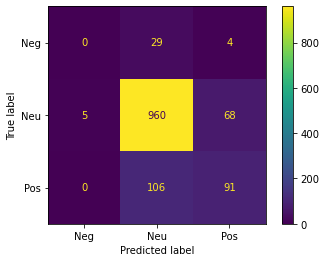

In [90]:
plot_confusion_matrix(nv_model, X_test, Y_test)

# Logistics Regression 

In [91]:
# logistic regression
lr_model = LogisticRegression()
lr_model.fit(X_test, Y_test)

LogisticRegression()

In [92]:
lr_model.score(X_test, Y_test)

0.9113222486144101

In [93]:
# single predict
predict_emotion(sample_txt, lr_model)

Prediction: Neu, Prediction Score: 0.7686230200689185 


{'Neg': array([0.03131257, 0.76862302, 0.20006441])}